In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pachner_traversal.utils import data_path, set_style, compute_rhat

set_style()

In [3]:
mcmc_result_path = data_path / "results" / "mcmc" / "generic_samples" / "20251004_1845"
assert mcmc_result_path.exists()

In [4]:
tet_map = {l: i for i, l in enumerate('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')}

In [5]:
def get_mcmc_scores_df(result_path, metric='agg_score_alex_norm'):
    isos_df = pd.read_csv(result_path / 'isos_lists.csv')
    scores_df = pd.read_csv(result_path / 'composite_scores.csv', index_col=0)

    scores_series = scores_df[metric]
    scores_map = scores_series.to_dict()

    chain_scores_df = isos_df.apply(lambda x: x.map(scores_map), axis=1)
    return chain_scores_df

In [6]:
metrics = [
    "agg_score_alex_norm",
    "agg_score_alex_deg",
    "agg_score_alex_det",
    "agg_score_edge_var",
    "agg_score_num_gen",
]

# mcmc_chain_scores = {}

# for metric in metrics:
#     mcmc_chain_scores_df = get_mcmc_scores_df(mcmc_result_path, metric)
#     mcmc_chain_scores[metric] = mcmc_chain_scores_df
#     rhat = compute_rhat(mcmc_chain_scores_df)[0]
#     print(f'{metric:20} | Rhat: {rhat:.3f}')

In [7]:
isos_df = pd.read_csv(mcmc_result_path / 'isos_lists.csv')
score_df = pd.read_csv(mcmc_result_path / f'agg_score_alex_det_chains.csv', index_col=0)

In [8]:
tet_30_filter = isos_df.map(lambda x: x.startswith('E')).values.flatten()
tet_30_scores = score_df.values.flatten()[tet_30_filter]

In [49]:
for metric in metrics:
    df = pd.read_csv(mcmc_result_path / f'{metric}_chains.csv', index_col=0)
    rhat, ess = compute_rhat(df)
    print(f'{metric:20} & {rhat:.3f} & {ess:,.0f} \\\\')

agg_score_alex_norm  & 1.003 & 69,540 \\
agg_score_alex_deg   & 1.004 & 69,500 \\
agg_score_alex_det   & 1.005 & 69,319 \\
agg_score_edge_var   & 1.006 & 69,131 \\
agg_score_num_gen    & 1.009 & 68,769 \\


In [9]:
def fit_alpha(all_data, x_min):
    data = all_data[all_data >= x_min]

    n = len(data)
    sum_log = np.sum(np.log(data / x_min))
    alpha = 1 + n / sum_log
    return alpha, (alpha - 1) * x_min**(alpha - 1)

def cdf(x, alpha, x_min):
    return 1 - (x/x_min)**(1 - alpha)

def get_ks_stat(all_data, x_min):
    alpha, C = fit_alpha(all_data, x_min)
    data = all_data[all_data >= x_min]
    data = np.sort(data)
    emp_cdf = np.arange(1, len(data)+1) / len(data)

    return np.max(np.abs(cdf(data, alpha, x_min) - emp_cdf))

In [10]:
def get_xmin(data):
    candidate_xmins = np.sort(np.unique(data))[:-1]
    ks_stats = [get_ks_stat(data, x_min) for x_min in candidate_xmins]
    x_min = candidate_xmins[np.argmin(ks_stats)]
    return x_min

In [21]:
import matplotlib.patches as patches

In [ ]:
bin_edges[i]

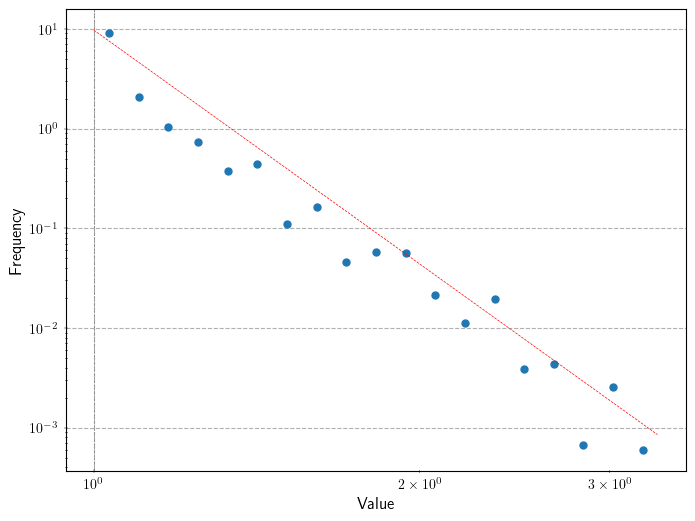

In [25]:
data = tet_30_scores
data = data[data > 0]

# x_min = get_xmin(data)
x_min = data.min()
sub_data = data[data >= x_min]

alpha, C = fit_alpha(sub_data, x_min)
C = C * len(sub_data) / len(data)

min_val = np.min(data)
max_val = np.max(data)
log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=20)

counts, bin_edges = np.histogram(data, bins=log_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1:] - bin_edges[:-1]
counts = counts / (len(data) * bin_width)

non_zero_indices = counts > 0
x_values = bin_centers[non_zero_indices]
y_values = counts[non_zero_indices]

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, "o", markersize=5, label="Power Law Data Binned")

plt.plot(
    [x_min, max_val],
    [10**(0.98707984) * x_min ** (-7.77956294), 10**(0.98707984) * max_val ** (-7.77956294)],
    color="r",
    label=f"Fit: $\\alpha={alpha:.2f}$",
    ls="--",
)


plt.axvline(x_min, color="gray", linestyle="--", label=f"$x_{{min}}={x_min}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

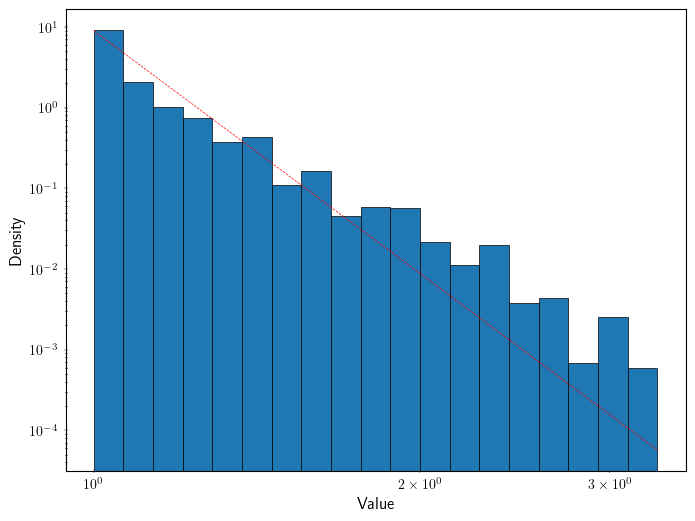

In [75]:
data = tet_30_scores
alpha, C = fit_alpha(data, data.min())


def get_area(bin_start, bin_end, alpha, C):
    return C * (bin_end ** (1 - alpha) - bin_start ** (1 - alpha)) / (1 - alpha)


fig, ax = plt.subplots(figsize=(8, 6))

# ax.hist(data, bins=20, density=True)
ax.plot(np.sort(data), C*np.sort(data)**(-alpha), color='r', ls='--')

true_area = 0

for i in range(len(counts)):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]
    bin_height = counts[i]

    # bin_height_true = get_area(bin_start, bin_end, alpha, C) / (bin_end - bin_start)

    rect = patches.Rectangle(
        (bin_start, 0),
        bin_end - bin_start,
        bin_height,
        linewidth=0.5,
        edgecolor="black",
        facecolor="C0",
    )
    # rect_true = patches.Rectangle((bin_start, 0), bin_end - bin_start, bin_height_true, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    # ax.add_patch(rect_true)
# ax.scatter(bin_centers, counts, color='blue', label='Binned Data', s=10)


scale = 1.1
x_min = np.max(bin_edges) * (1 - scale) / 2 + np.min(bin_edges) * (1 + scale) / 2
x_max = np.max(bin_edges) * (1 + scale) / 2 + np.min(bin_edges) * (1 - scale) / 2
y_min = np.max(counts) * (1 - scale) / 2
y_max = np.max(counts) * (1 + scale) / 2


# ax.set_xlim(x_min, x_max)
# ax.set_ylim(0, y_max)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Value")
plt.ylabel("Density")
plt.savefig(mcmc_result_path / "tet_30_scores_histogram.pdf", bbox_inches="tight")

# plt.grid()
plt.show()

In [74]:
mcmc_result_path

PosixPath('/home/dbruwel/main/honours/pachner_graph_triangulations/data/results/mcmc/generic_samples/20251004_1845')

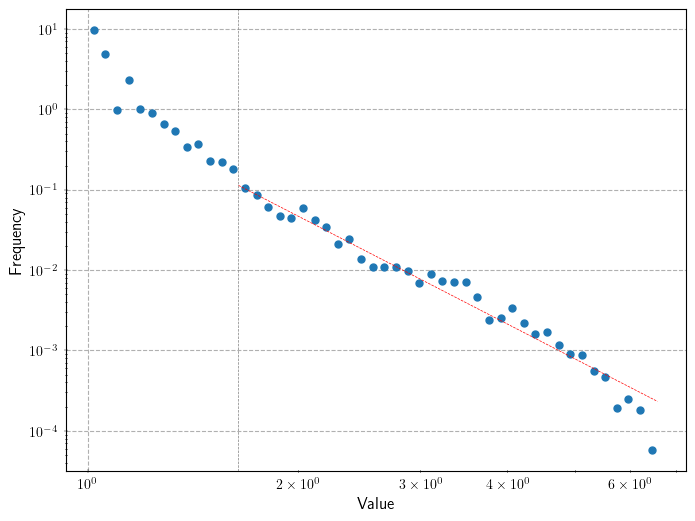

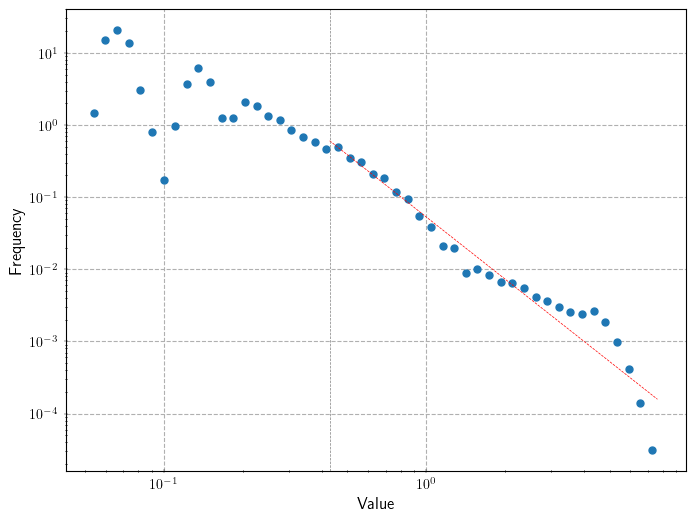

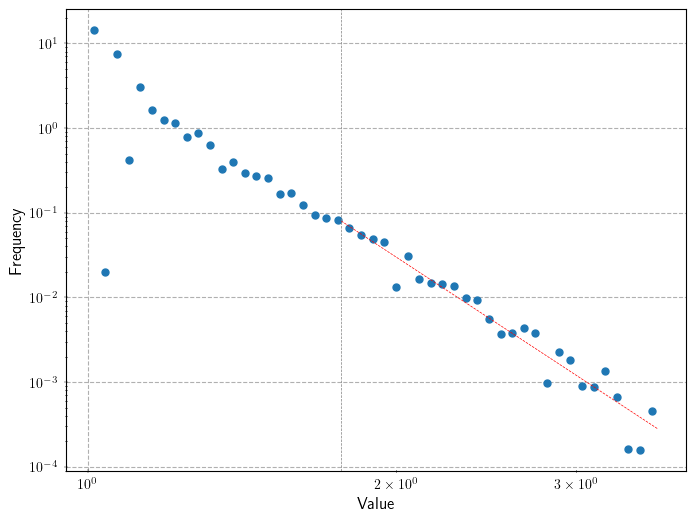

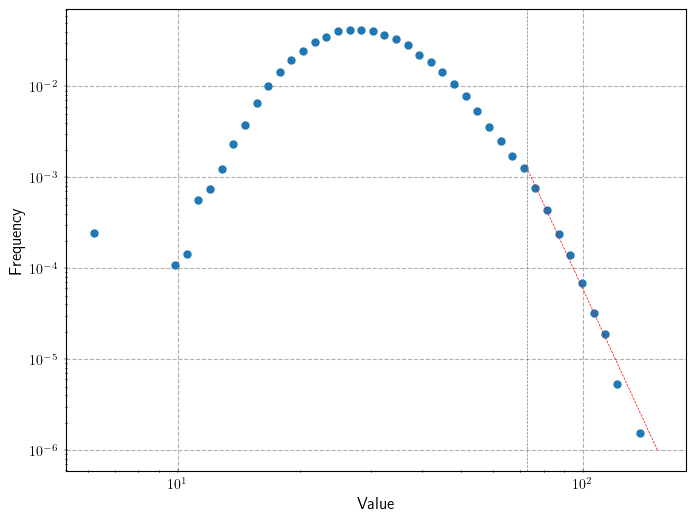

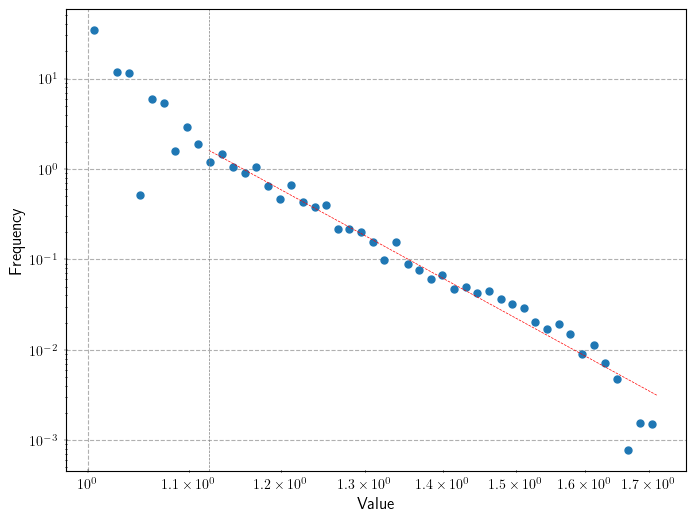

In [116]:
for metric in metrics:
    df = pd.read_csv(mcmc_result_path / f'{metric}_chains.csv', index_col=0)
    data = df.values.flatten()
    data = data[data > 0]

    x_min = get_xmin(data)
    sub_data = data[data >= x_min]

    alpha, C = fit_alpha(sub_data, x_min)
    C = C*len(sub_data)/len(data)

    min_val = np.min(data)
    max_val = np.max(data)
    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=50)

    counts, bin_edges = np.histogram(data, bins=log_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1:] - bin_edges[:-1]
    counts = counts / (len(data) * bin_width)

    non_zero_indices = counts > 0
    x_values = bin_centers[non_zero_indices]
    y_values = counts[non_zero_indices]

    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, 'o', markersize=5, label='Power Law Data Binned')
    plt.plot([x_min, max_val], [C * x_min**(-alpha), C * max_val**(-alpha)], color='r', label=f'Fit: $\\alpha={alpha:.2f}$', ls='--')
    plt.axvline(x_min, color='gray', linestyle='--', label=f'$x_{{min}}={x_min}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid()
    plt.savefig(f'{metric}_log_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()